# EDA & Vintage Analysis with Credit Card Loan Data

## **Goal**  
The goal of this exercise is to perform EDA and Vintage Analysis on "Credit Card Approval Prediction" dataset to understand factors influencing credit card approval decisions and evaluate the performance of approved applications over time.

## Data

This exercise uses the "Credit Card Approval Prediction" dataset from: [Credit Card Approval Prediction](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction).  

This dataset contains data on credit card applications and their status (approved or rejected).


## EDA
Perform the following steps
- Import data from source
- Clean data (missing values, outliers, data format...)
- Add necesssary columns for analysis

### Import Data

In [4]:
import kagglehub
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta

In [5]:
# Download latest version
path = kagglehub.dataset_download("rikdifos/credit-card-approval-prediction")
df_app = pd.read_csv(path+"/application_record.csv")
df_cred = pd.read_csv(path+"/credit_record.csv")


### Clean Credit Record Table

In [6]:

df_cred.info()
df_cred.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [7]:
# Duplicates
df_cred.duplicated().sum()

np.int64(0)

In [8]:
# Missing Values
df_cred.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [9]:
# Add Column

get_date_by_rel_month = lambda x:  (dt.datetime.today().date() + relativedelta(months=x))
 
df_cred["MONTH"] = pd.to_datetime( df_cred["MONTHS_BALANCE"].apply(get_date_by_rel_month) )

# Check new column's dtype
print(df_cred["MONTH"].dtype)

df_cred.head()

datetime64[ns]


,ID,MONTHS_BALANCE,STATUS,MONTH
0,5001711,0,X,2025-07-26
1,5001711,-1,0,2025-06-26
2,5001711,-2,0,2025-05-26
3,5001711,-3,0,2025-04-26
4,5001712,0,C,2025-07-26


In [10]:
df_cred["STATUS"].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

In [11]:
df_cred_backup = df_cred.copy()

df_cred = df_cred.sort_values(["ID","MONTH"]).reset_index(drop=True)
df_cred["LAST_MONTH_STATUS"] = df_cred.groupby("ID")["STATUS"].shift( 1)
df_cred.head()

,ID,MONTHS_BALANCE,STATUS,MONTH,LAST_MONTH_STATUS
0,5001711,-3,0,2025-04-26,NaN
1,5001711,-2,0,2025-05-26,0
2,5001711,-1,0,2025-06-26,0
3,5001711,0,X,2025-07-26,0
4,5001712,-18,0,2024-01-26,NaN


In [12]:
# 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 
# 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

stat_closed = ["X"]

def mark_loan_end_start(curr, last, month):
    if  ( ( pd.isna( last )) | ( last in  stat_closed) ):
        return month
    
df_cred["LOAN_START_MONTH"] = df_cred.apply(lambda row: mark_loan_end_start(row["STATUS"], row["LAST_MONTH_STATUS"], row["MONTH"]), axis=1).fillna(method="ffill")
df_cred["LOAN_ID"] = df_cred["ID"].astype(str) + df_cred["LOAN_START_MONTH"].dt.strftime("%Y%m%d")
df_cred.drop(["LAST_MONTH_STATUS"], inplace=True, axis=1)
df_cred.head()

/var/folders/01/n82t7n011pvf7zt10542lvdm0000gn/T/ipykernel_12918/2401325843.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cred["LOAN_START_MONTH"] = df_cred.apply(lambda row: mark_loan_end_start(row["STATUS"], row["LAST_MONTH_STATUS"], row["MONTH"]), axis=1).fillna(method="ffill")


,ID,MONTHS_BALANCE,STATUS,MONTH,LOAN_START_MONTH,LOAN_ID
0,5001711,-3,0,2025-04-26,2025-04-26,500171120250426
1,5001711,-2,0,2025-05-26,2025-04-26,500171120250426
2,5001711,-1,0,2025-06-26,2025-04-26,500171120250426
3,5001711,0,X,2025-07-26,2025-04-26,500171120250426
4,5001712,-18,0,2024-01-26,2024-01-26,500171220240126


In [13]:
df_cred_filtered = df_cred[df_cred["STATUS"] != "X"].copy()
print(f"Number of Customers: {df_cred_filtered["ID"].nunique()}")
print(f"Number of Loans: {df_cred_filtered["LOAN_ID"].nunique()}")

Number of Customers: 41449
Number of Loans: 61379


In [14]:
df_cred_filtered["MONTH_FROM_START"] = df_cred_filtered.groupby(["ID","LOAN_ID"])["MONTH"].rank().astype(np.int64) - 1
df_cred_filtered.head(10)

,ID,MONTHS_BALANCE,STATUS,MONTH,LOAN_START_MONTH,LOAN_ID,MONTH_FROM_START
0,5001711,-3,0,2025-04-26,2025-04-26,500171120250426,0
1,5001711,-2,0,2025-05-26,2025-04-26,500171120250426,1
2,5001711,-1,0,2025-06-26,2025-04-26,500171120250426,2
4,5001712,-18,0,2024-01-26,2024-01-26,500171220240126,0
5,5001712,-17,0,2024-02-26,2024-01-26,500171220240126,1
6,5001712,-16,0,2024-03-26,2024-01-26,500171220240126,2
7,5001712,-15,0,2024-04-26,2024-01-26,500171220240126,3
8,5001712,-14,0,2024-05-26,2024-01-26,500171220240126,4
9,5001712,-13,0,2024-06-26,2024-01-26,500171220240126,5
10,5001712,-12,0,2024-07-26,2024-01-26,500171220240126,6


### Clean Application Record Table

In [15]:
df_app["CNT_FAM_MEMBERS"] = df_app["CNT_FAM_MEMBERS"].astype(np.int64)

get_date_by_rel_date = lambda x:  (dt.datetime.today().date() + relativedelta(days=x))
df_app["DATE_BIRTH"] = pd.to_datetime( df_app["DAYS_BIRTH"].apply(get_date_by_rel_date) )
df_app["AGE"] = dt.datetime.today().year - df_app["DATE_BIRTH"].dt.year

df_app.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,DATE_BIRTH,AGE
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000,438557,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465,1981-10-07 02:17:18.356245440,43.737042
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000,1956-07-27 00:00:00,20.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000,1972-03-23 00:00:00,34.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000,1982-10-10 00:00:00,43.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000,1991-04-22 00:00:00,53.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,2005-01-23 00:00:00,69.000000
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207,NaN,11.463959


In [16]:
df_app.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
DATE_BIRTH                  0
AGE                         0
dtype: int64

In [17]:
df_app["OCCUPATION_TYPE"].value_counts()

OCCUPATION_TYPE
Laborers                 78240
Core staff               43007
Sales staff              41098
Managers                 35487
Drivers                  26090
High skill tech staff    17289
Accountants              15985
Medicine staff           13520
Cooking staff             8076
Security staff            7993
Cleaning staff            5845
Private service staff     3456
Low-skill Laborers        2140
Secretaries               2044
Waiters/barmen staff      1665
Realty agents             1041
HR staff                   774
IT staff                   604
Name: count, dtype: int64

In [18]:
df_app[df_app["OCCUPATION_TYPE"].isna()]["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Pensioner               75357
Working                 35886
Commercial associate    16745
State servant            6210
Student                     5
Name: count, dtype: int64

In [19]:
df_app["OCCUPATION_TYPE"] = df_app["OCCUPATION_TYPE"].fillna(value=df_app["NAME_INCOME_TYPE"]).replace({"Working":"Unknown"})
df_app.isna().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
DATE_BIRTH             0
AGE                    0
dtype: int64

### Univariate Analysis

**Count of Children & Family Members**
- Heavily right skewed by a few customers with over 15 children/family members.
- Majority of observations have fewer than 5 children/family members.

**Age & Days Bith**
- Roughly uniformly distributed between 30 and 60 years old.
- Few observations are under 20, or over 60.

**Total Income**
- Heavily right skewed. Majority of values are under 1,000,0000

**Days Employed**
- Heavily Right skewed. Majority of values center around 0.




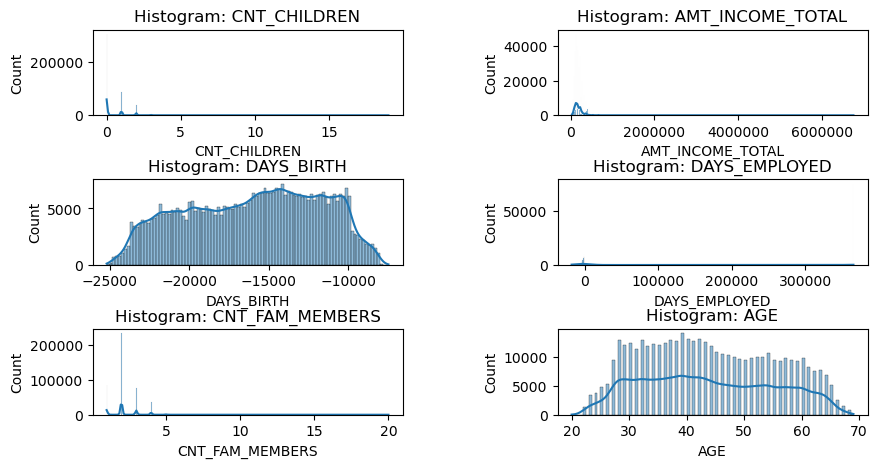

In [20]:
col_numeric = df_app.select_dtypes(include="number").columns

col_numeric = [i for i in col_numeric if (not "FLAG" in i) & (not "ID" in i)]

num_col = int( np.ceil(len(col_numeric) / 3) )

fig, axes = plt.subplots(3,  num_col, figsize = (num_col* 5, 5))

axes = axes.ravel()

fig.subplots_adjust(wspace=0.5, hspace=0.75)

for i, ax in  zip(range(len(col_numeric)), axes):
    sns.histplot(df_app, x = col_numeric[i],
                 kde=True, 
                 ax=ax)
    ax.set_title(f"Histogram: {col_numeric[i]}")
    ax.ticklabel_format(style='plain')

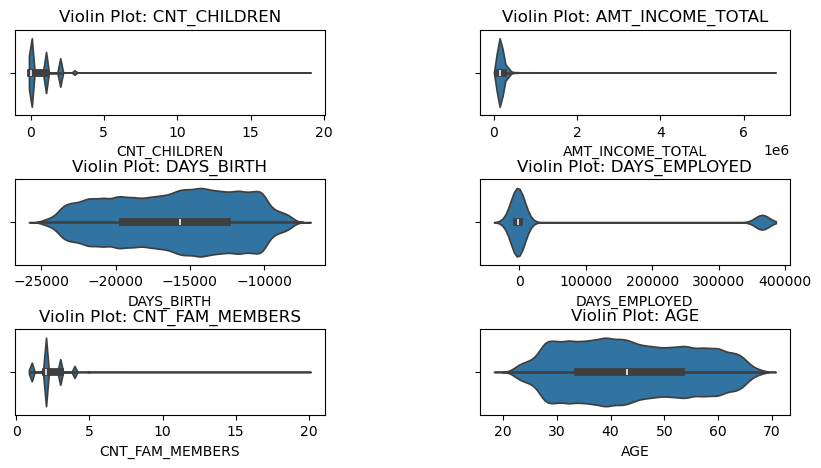

In [21]:
fig, axes = plt.subplots(3,  num_col, figsize = (num_col* 5, 5))

axes = axes.ravel()

fig.subplots_adjust(wspace=0.5, hspace=0.75)

for i, ax in  zip(range(len(col_numeric)), axes):
    sns.violinplot(df_app, x = col_numeric[i],
                 ax=ax)
    ax.set_title(f"Violin Plot: {col_numeric[i]}")

**Gender**
- There are twice as many Females as Males

**Realty Ownership**
- There are twice as many applicants that own realty than those who do not.

**Car Ownership**
- There are twice as many applicants that do not own cars than those who do.

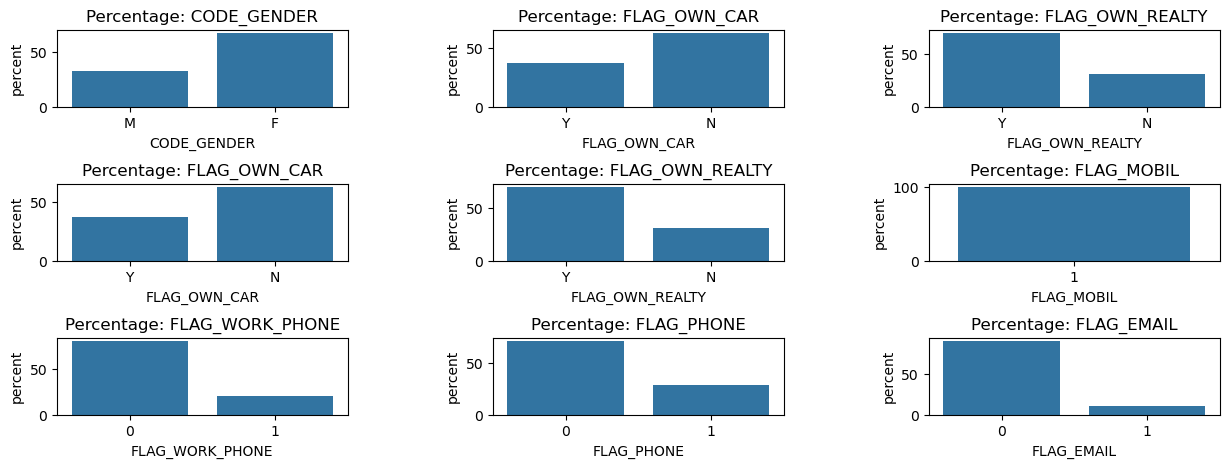

In [22]:
col_categorical = df_app.select_dtypes(include="object").columns.to_list()
col_categorical.extend(  [ i for i in df_app.columns if "FLAG" in i] )

col_cat_2_or_less = [i for i in col_categorical if df_app[i].nunique() <= 2]
col_cat_over_2 = [i for i in col_categorical if df_app[i].nunique() >= 3]

num_col = int( np.ceil(len(col_cat_2_or_less) / 3) )

fig, axes = plt.subplots(3,  num_col, figsize = (num_col * 5, 5))

axes = axes.ravel()

fig.subplots_adjust(wspace=0.5, hspace=1)

for i, ax in  zip(range(len(col_cat_2_or_less)), axes):
    sns.countplot(df_app, x= col_cat_2_or_less[i],
                  stat="percent",
                 ax=ax)
    ax.set_title(f"Percentage: {col_cat_2_or_less[i]}")


**Education Type**
- Applicants with Secondary/Secondary special hold the highest proportion, followed by those with education.

**Family Status**
- Most applicants are married.

**Housing Types**
- Most applicants live in a house or appartment.

**Occupation Type**
- The highest proportion of applicants are pensioners or laborers, followed by core staff, sales staff and those with unknown occupation.
- Students, Realty Agent, HR Staff, Waiters represent the smallest proportion.


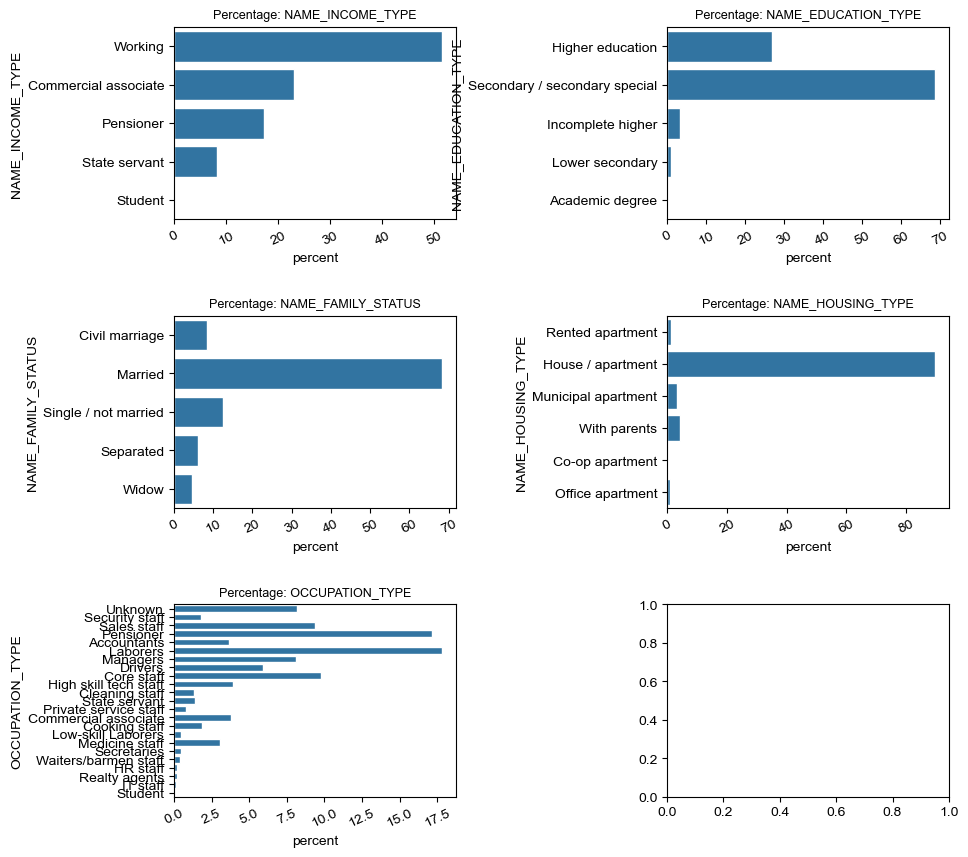

In [23]:
num_col = int( np.ceil(len(col_cat_over_2) / 3) )

fig, axes = plt.subplots(3,  num_col, figsize = (num_col * 5, 10))

axes = axes.ravel()

fig.subplots_adjust(wspace=0.75, hspace=0.5)

sns.set(font_scale = 0.75)

for i, ax in  zip(range(len(col_cat_over_2)), axes):
    sns.countplot(df_app, y= col_cat_over_2[i],
                  stat="percent", orient="v",
                 ax=ax)
    ax.set_title(f"Percentage: {col_cat_over_2[i]}")
    ax.xaxis.set_tick_params(labelrotation = 25)



### Bivariate Analysis

**Summary**

- People in the highest income brackets are more likely to be in good standing with their debt.
- Sales Staff, HR Staff, IT Staff, Low skill Laborers and Realty Agents are slightly more likely to be in good standing, but more statstical testing is needed to check if the diffrence is significant.
- There isn't a clear trend regarding deliquency based on age group - as in, it is hard to definitively say they older people are likely to pay off their loan on time.
- People aged 65 or older are slightly more likely to be good standing than the other age groups. However, given that the debt is significantly past due, they are also more likely to go over 150 days past due.


**Loan Status & Income**

- Applicants whose latest credit card balance was either Paid off or between 1 and 59 days past due have similar Income Distribution with a heavy right skew.
- The income distribution of applicants whose latest Loans were between 60 and 149 days overdue are more concentrated on the lower end of the income range
- However, the median income for all statuses are not significantly different.
- Notably, overdue loans or bad debts have a wider distribution than that of the previous loan status tiers.
- This suggests that certain customers with high risk of deliquency will fail to pay off their loans regardless of income, but overall higher income is negatively correlated with deliquency.


In [24]:
df_app_joined = df_app.join(
    df_cred_filtered.groupby(["ID","LOAN_ID"])["STATUS"].last().reset_index().set_index("ID"),
    on = "ID", how="inner")

plot_order = ["C","0","1","2","3","4","5"]

df_app_joined["STATUS"] = pd.Categorical(values = df_app_joined["STATUS"]  , categories= plot_order)
df_app_joined["OCCUPATION_TYPE"] = pd.Categorical(values = df_app_joined["OCCUPATION_TYPE"]  , categories= df_app_joined["OCCUPATION_TYPE"].unique())


Text(0.5, 1.0, 'Violin Plot: Total Income vs. Latest Loan Status')

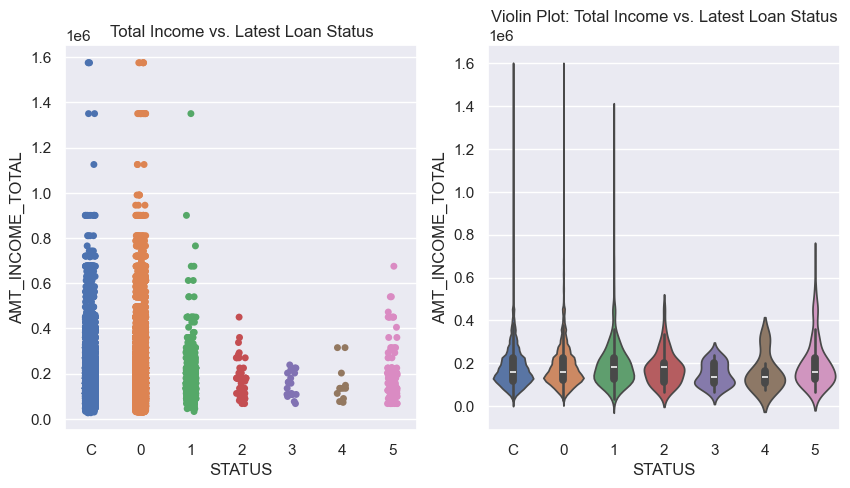

In [ ]:
sns.set(font_scale = 1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10, 5))


sns.stripplot(df_app_joined, x="STATUS", y ="AMT_INCOME_TOTAL", hue = "STATUS", order=plot_order, ax=ax1)
ax1.set_title("Total Income vs. Latest Loan Status")

sns.violinplot(df_app_joined, x="STATUS", y ="AMT_INCOME_TOTAL", hue = "STATUS", order=plot_order, ax=ax2)
ax2.set_title("Violin Plot: Total Income vs. Latest Loan Status")

plt.show()

**Loan Status & Occupation Type**

Accross occupation types, people are more likely to pay on time or only 1-49 days past due than not.

Sales Staff, HR Staff, IT Staff, Low skill Laborers and Realty Agents are groups with highest percentage of paid-on-time loans.

However, in the 1-49 days late bracket, the remaining occupations are in better standing than the above mentioned group.

Students are outliers as they all paid their debt on time. But the number of loans made students are comparativley small. Therefore, this compliance rate may not be representative of students as a population.

In [26]:
status_by_occ_type = pd.crosstab(df_app_joined["OCCUPATION_TYPE"], df_app_joined["STATUS"], normalize="index" )
status_by_occ_type

STATUS,C,0,1,2,3,4,5
OCCUPATION_TYPE,,,,,,,
Unknown,0.381678,0.605028,0.010636,0.001209,0.000000,0.000242,0.001209
Security staff,0.358389,0.614765,0.017450,0.002685,0.000000,0.000000,0.006711
Sales staff,0.422652,0.558513,0.016072,0.000502,0.000251,0.000251,0.001758
Pensioner,0.377365,0.607916,0.009771,0.000989,0.001484,0.000371,0.002103
Accountants,0.375078,0.610592,0.012461,0.000000,0.000000,0.000000,0.001869
Laborers,0.401287,0.583526,0.011712,0.000901,0.000386,0.000386,0.001802
Managers,0.392385,0.586281,0.015393,0.001080,0.000000,0.000270,0.004591
Drivers,0.391209,0.591941,0.011722,0.002564,0.000000,0.000366,0.002198
Core staff,0.363882,0.618662,0.011638,0.001455,0.000623,0.000208,0.003533


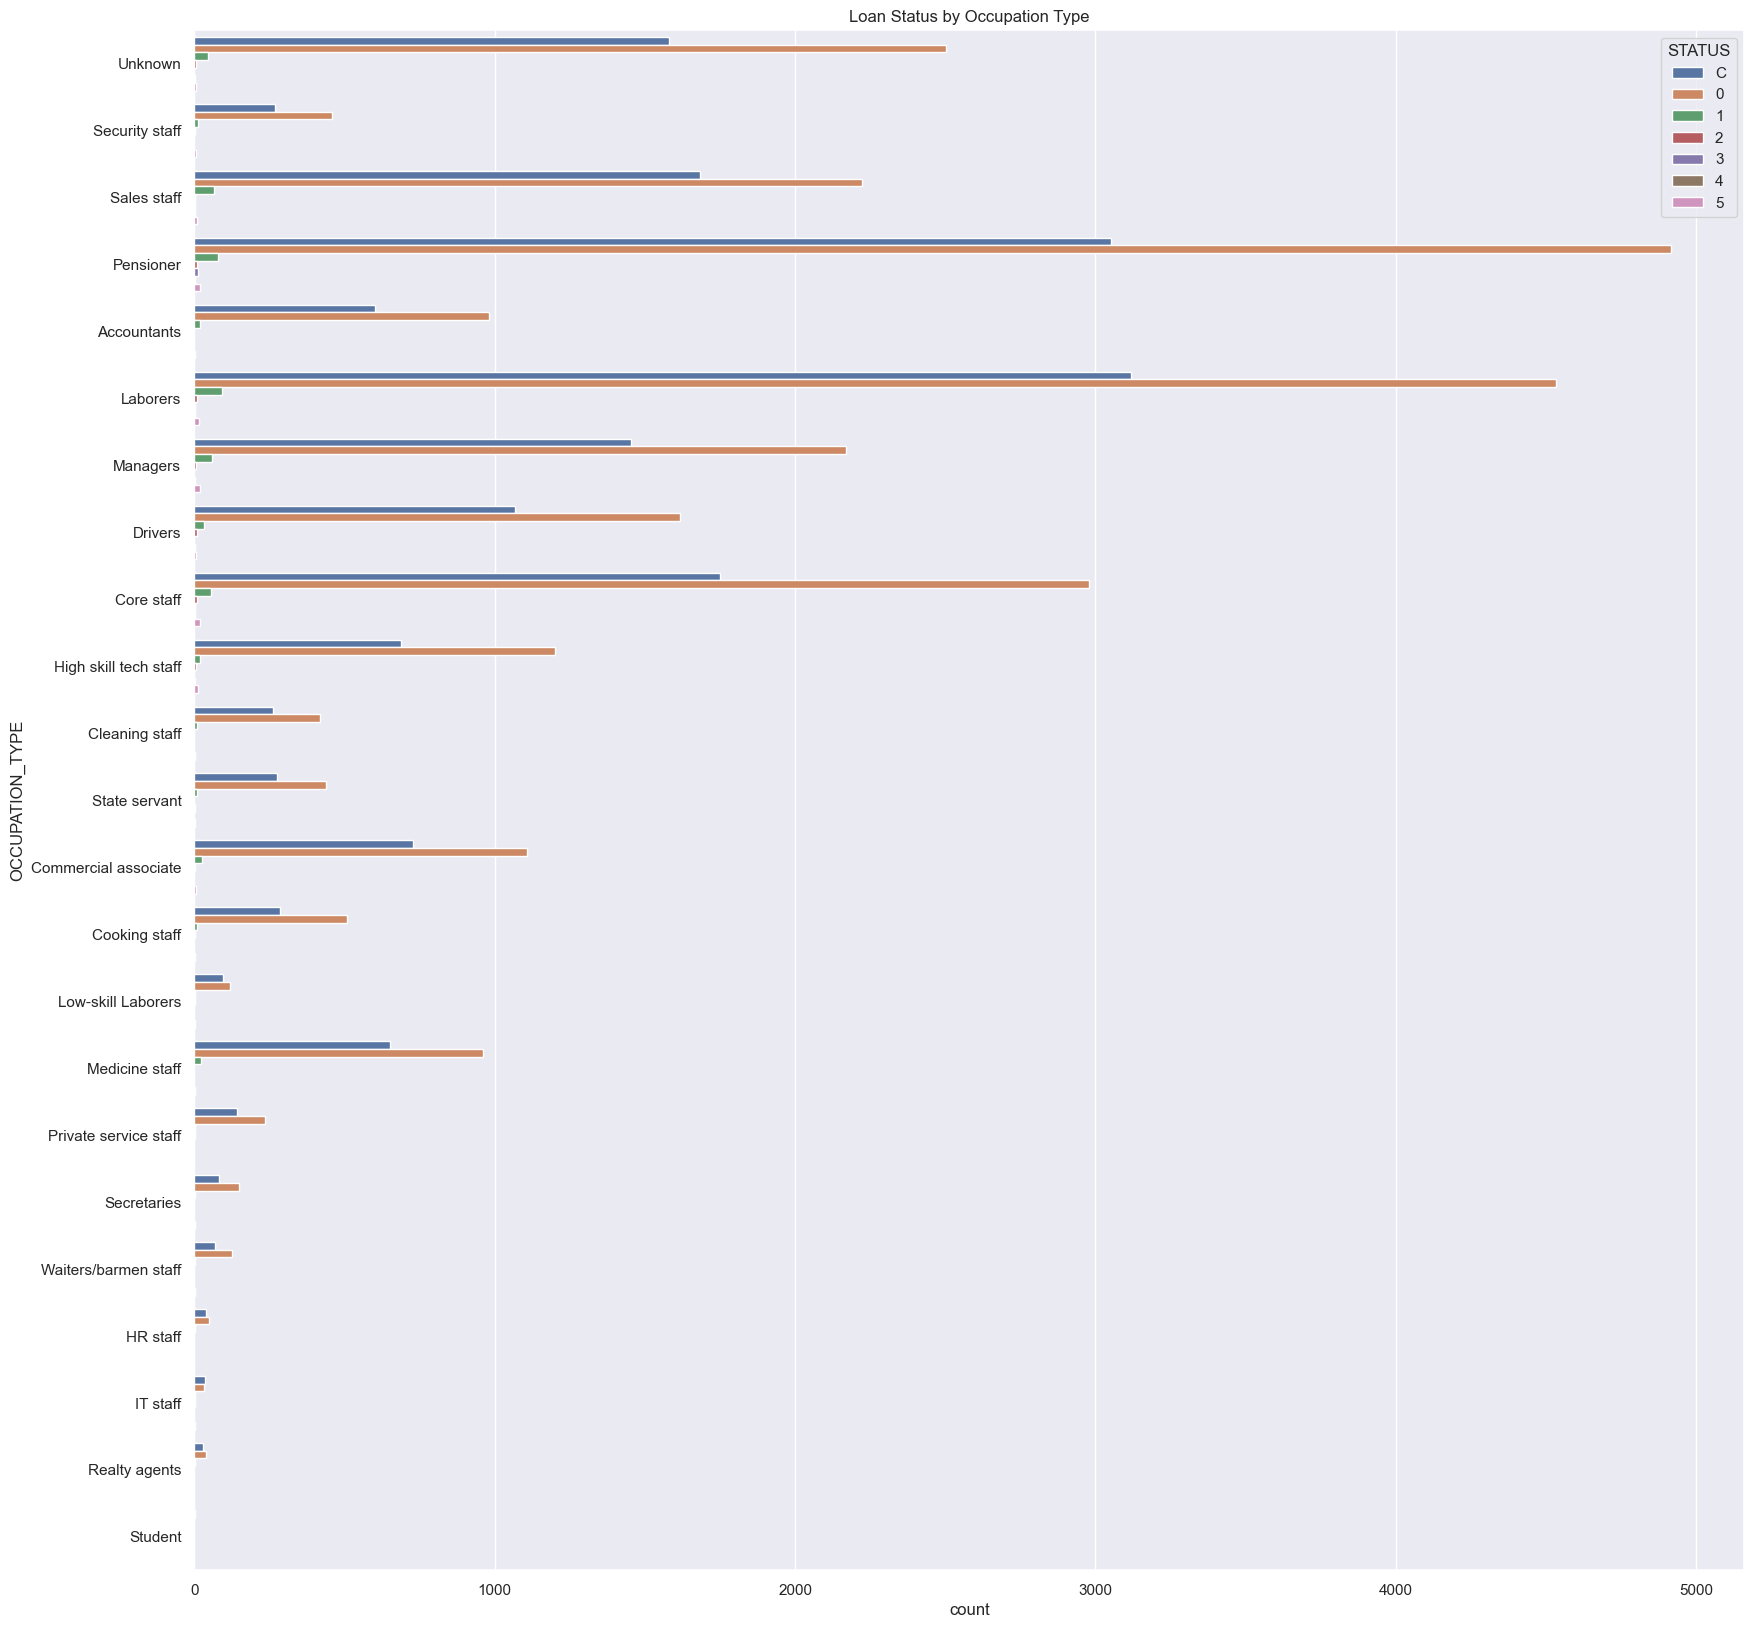

In [27]:

fig,ax = plt.subplots(figsize= (20, 20))
sns.countplot(data=df_app_joined, y="OCCUPATION_TYPE", hue="STATUS", orient="v", stat="count" , ax = ax)
ax.set_title("Loan Status by Occupation Type")
plt.show()


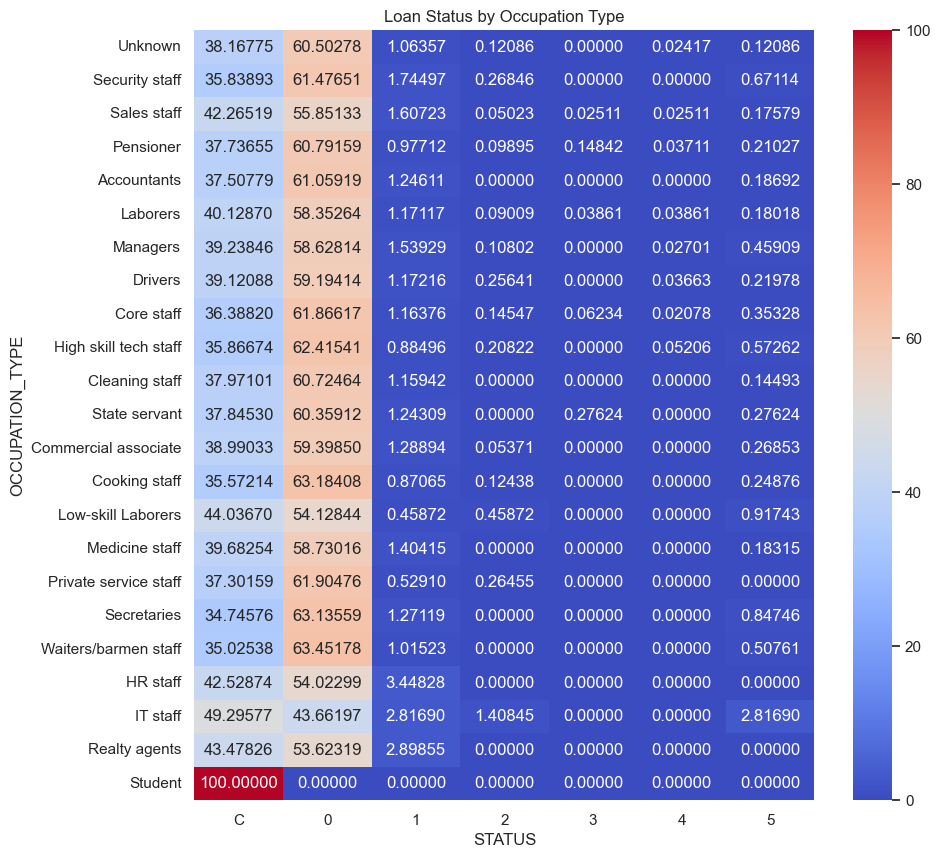

In [28]:
fig,ax = plt.subplots(figsize= (10, 10))
ax = sns.heatmap(status_by_occ_type * 100.0, annot=True, fmt=".5f", cmap="coolwarm")
ax.set_title("Loan Status by Occupation Type")
plt.show()

In [29]:
bin_edge = range(20,71,5)
df_app_joined["AGE_GROUP"] = pd.cut(df_app_joined["AGE"], bins = bin_edge)

**Loan Status & Age Groups**

Accross age groups, people are more likely to pay on time or only 1-49 days past due than later.

People 65 to 70 years old are more likely to be in good standing, but not siginificantly so.

However, this group also has a higher percentage of loans which are overdue, written off or bad debt.

In [30]:
status_by_age_group = pd.crosstab(df_app_joined["AGE_GROUP"], df_app_joined["STATUS"], normalize="index" )
status_by_age_group

STATUS,C,0,1,2,3,4,5
AGE_GROUP,,,,,,,
"(20, 25]",0.375538,0.604651,0.018088,0.000000,0.000000,0.000000,0.001723
"(25, 30]",0.400559,0.577595,0.017826,0.001223,0.000000,0.000524,0.002272
"(30, 35]",0.411204,0.570232,0.015278,0.001479,0.000657,0.000329,0.000821
"(35, 40]",0.383449,0.600206,0.011486,0.000736,0.000147,0.000147,0.003829
"(40, 45]",0.385021,0.600287,0.010699,0.000639,0.000319,0.000160,0.002874
"(45, 50]",0.379479,0.608329,0.008816,0.000750,0.000188,0.000188,0.002251
"(50, 55]",0.377012,0.603145,0.011045,0.002621,0.000374,0.000187,0.005616
"(55, 60]",0.364196,0.625163,0.008214,0.000560,0.000373,0.000187,0.001307
"(60, 65]",0.385885,0.596804,0.012250,0.001065,0.002130,0.000533,0.001332


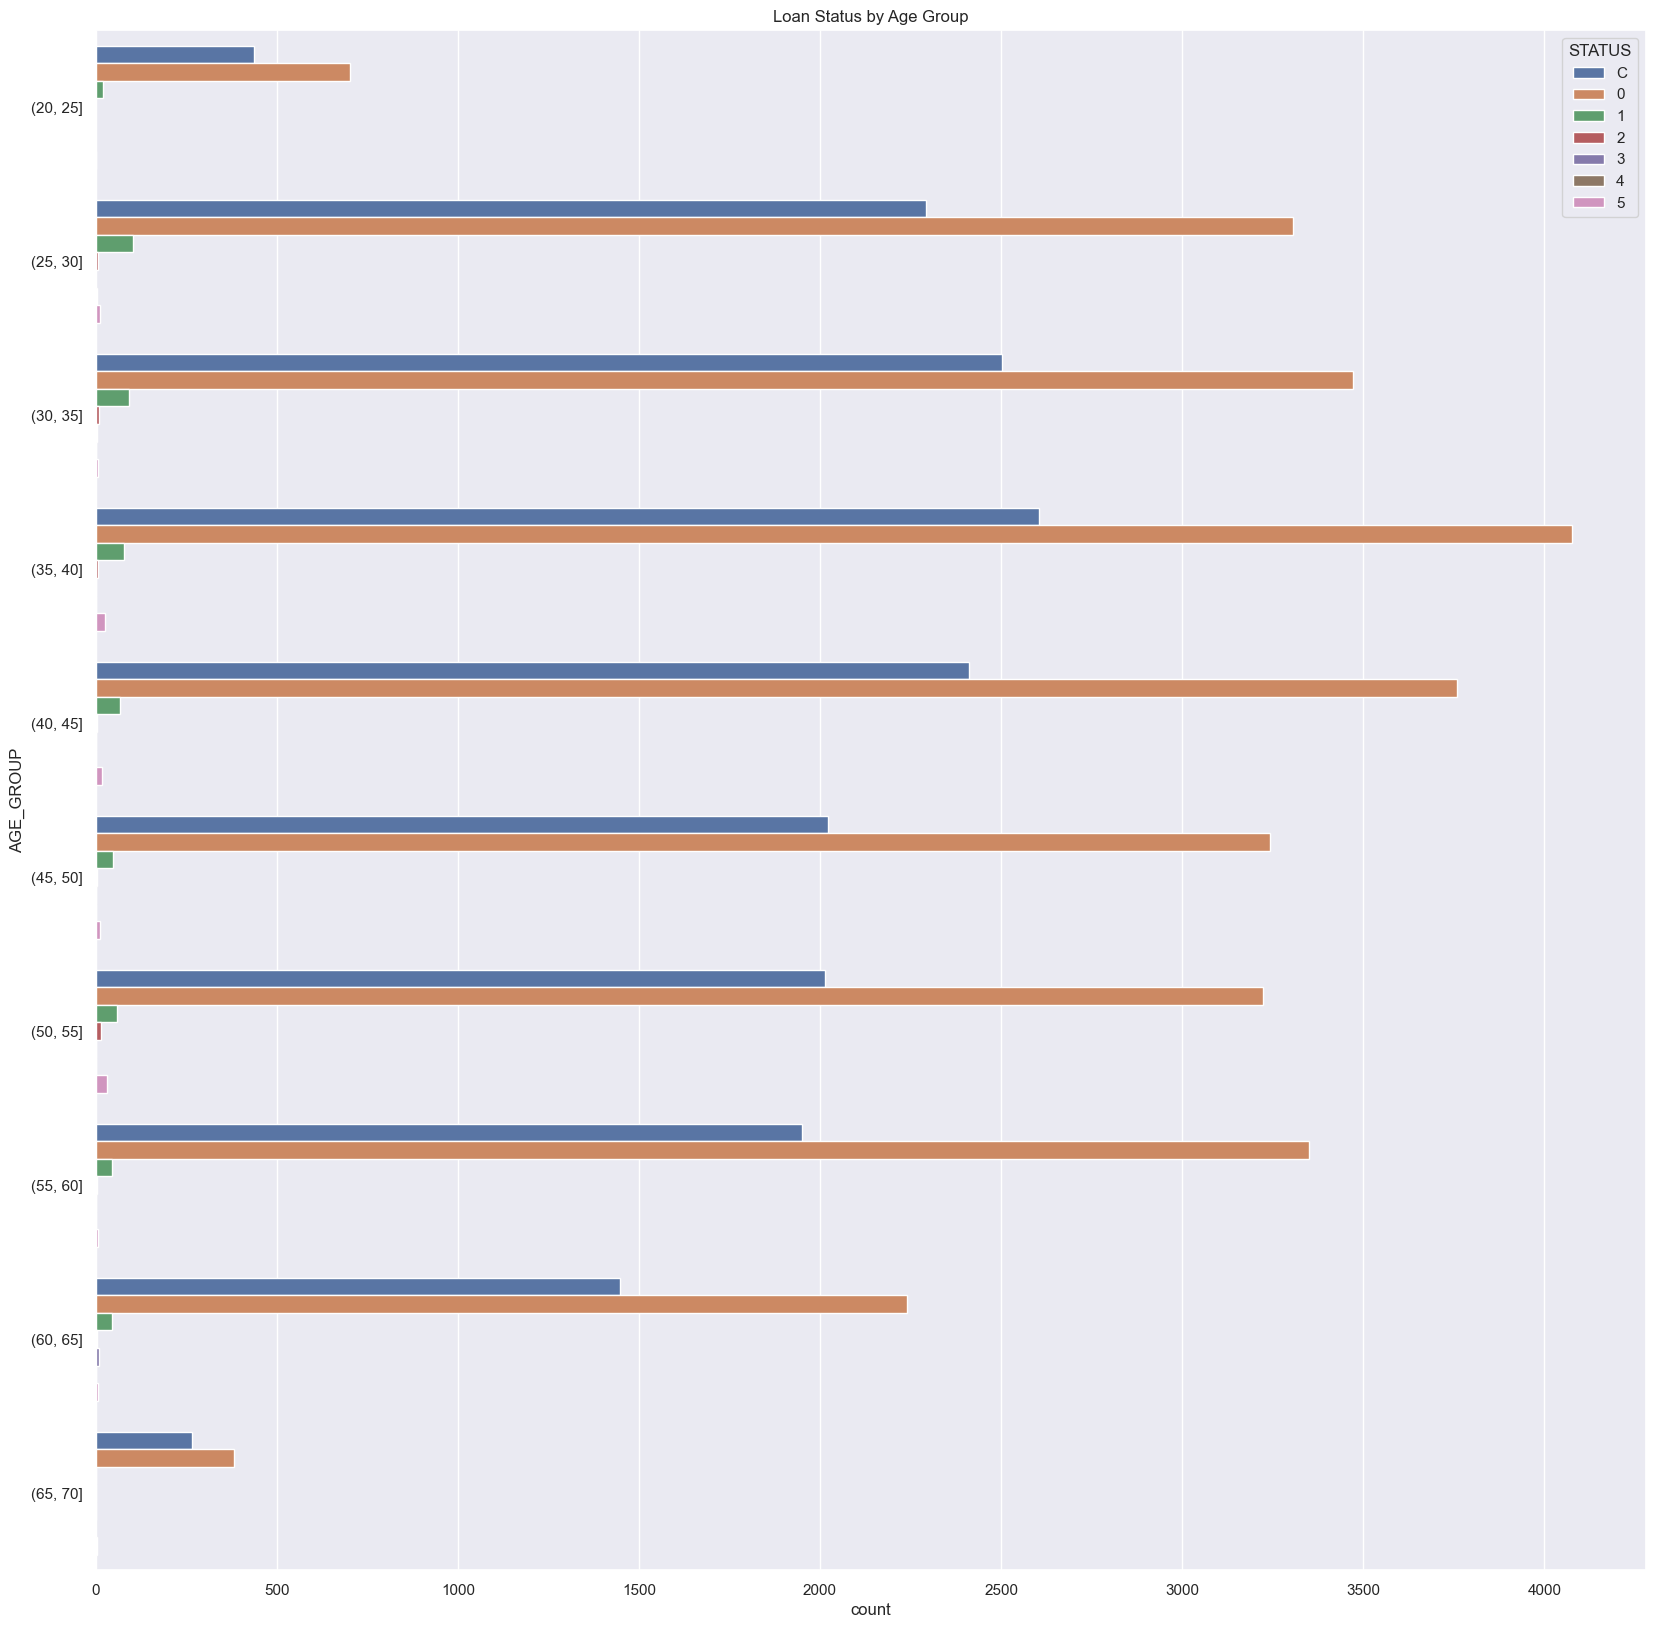

In [31]:
fig,ax = plt.subplots(figsize= (20, 20))
sns.countplot(data=df_app_joined, y="AGE_GROUP", hue="STATUS", orient="v", stat="count" , ax = ax)
ax.set_title("Loan Status by Age Group")
plt.show()

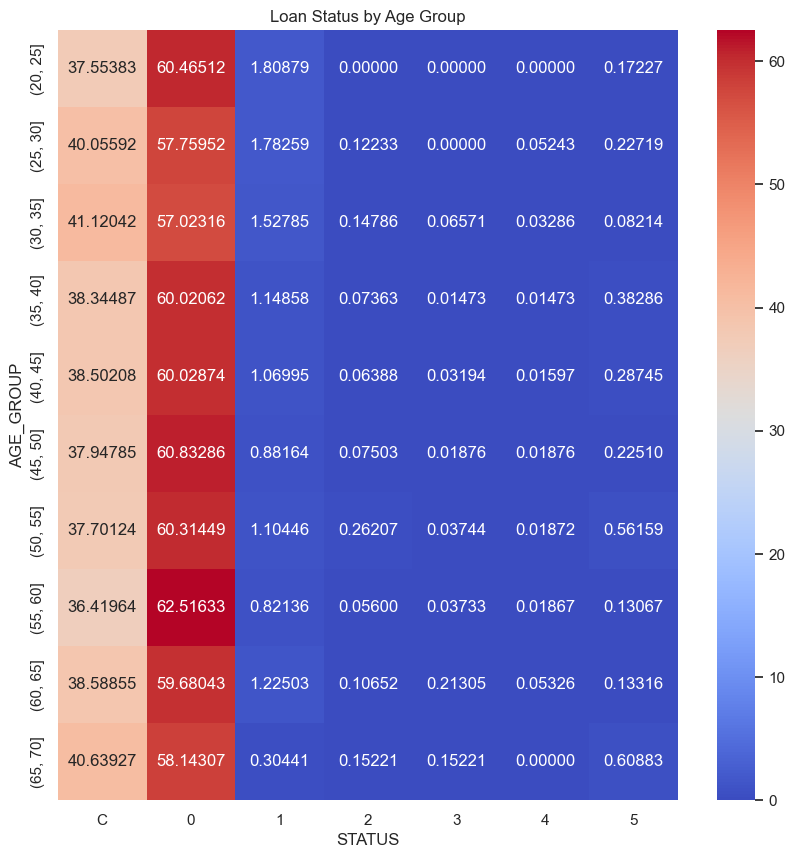

In [32]:
fig,ax = plt.subplots(figsize= (10, 10))
ax = sns.heatmap(status_by_age_group * 100.0, annot=True, fmt=".5f", cmap="coolwarm")
ax.set_title("Loan Status by Age Group")
plt.show()


---

## Vintage Analysis

## Prepare Data

Create Cohorts based Quarter start month.



In [33]:
df_cred_filtered["LOAN_QUARTER"] = df_cred_filtered["MONTH"].apply(lambda x: pd.Period(f"{x.year}Q{x.quarter}",  freq='Q') )
df_cred_filtered["LOAN_START_QUARTER"] = df_cred_filtered["LOAN_START_MONTH"].apply(lambda x: pd.Period(f"{x.year}Q{x.quarter}",  freq='Q') )

# Reference: https://stackoverflow.com/questions/76930535/calculate-difference-between-quarter-periods-in-pandas

df_cred_filtered["QUARTER_FROM_START"] = df_cred_filtered[["LOAN_QUARTER","LOAN_START_QUARTER"]]\
                                            .apply(lambda x: (x["LOAN_QUARTER"] - x["LOAN_START_QUARTER"]).n , axis =1)
df_cred_filtered.head(20)

,ID,MONTHS_BALANCE,STATUS,MONTH,LOAN_START_MONTH,LOAN_ID,MONTH_FROM_START,LOAN_QUARTER,LOAN_START_QUARTER,QUARTER_FROM_START
0,5001711,-3,0,2025-04-26,2025-04-26,500171120250426,0,2025Q2,2025Q2,0
1,5001711,-2,0,2025-05-26,2025-04-26,500171120250426,1,2025Q2,2025Q2,0
2,5001711,-1,0,2025-06-26,2025-04-26,500171120250426,2,2025Q2,2025Q2,0
4,5001712,-18,0,2024-01-26,2024-01-26,500171220240126,0,2024Q1,2024Q1,0
5,5001712,-17,0,2024-02-26,2024-01-26,500171220240126,1,2024Q1,2024Q1,0
6,5001712,-16,0,2024-03-26,2024-01-26,500171220240126,2,2024Q1,2024Q1,0
7,5001712,-15,0,2024-04-26,2024-01-26,500171220240126,3,2024Q2,2024Q1,1
8,5001712,-14,0,2024-05-26,2024-01-26,500171220240126,4,2024Q2,2024Q1,1
9,5001712,-13,0,2024-06-26,2024-01-26,500171220240126,5,2024Q2,2024Q1,1
10,5001712,-12,0,2024-07-26,2024-01-26,500171220240126,6,2024Q3,2024Q1,2


## Evaluate Loan Performance

- Calculate rate of default for each cohort at different time ranges (3 months, 6 months, 12 months...)
- Visualize rate of default


In [34]:
df_vintage_raw = df_cred_filtered[df_cred_filtered["STATUS"] == "5"].groupby(["LOAN_ID"]).first().reset_index()\
    .pivot_table(index="LOAN_START_QUARTER",columns="QUARTER_FROM_START", values="LOAN_ID", aggfunc="count")
df_vintage_raw.head()

QUARTER_FROM_START,0,1,2,3,4,5,6,7,8,9,10,11,12,13,19
LOAN_START_QUARTER,,,,,,,,,,,,,,,
2020Q3,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,1.0
2020Q4,NaN,2.0,1.0,5.0,NaN,3.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
2021Q1,1.0,NaN,2.0,2.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2021Q2,NaN,2.0,3.0,2.0,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
2021Q3,1.0,NaN,2.0,3.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN


In [35]:
df_cohort_count = df_cred_filtered.groupby("LOAN_START_QUARTER")["LOAN_ID"].nunique().reset_index().rename({"LOAN_ID": "COHORT_COUNT"}, axis=1)
df_cohort_count.head()

,LOAN_START_QUARTER,COHORT_COUNT
0,2020Q3,929
1,2020Q4,1148
2,2021Q1,1358
3,2021Q2,1690
4,2021Q3,1817


In [36]:
df_vintage_perc = df_cohort_count.join(df_vintage_raw, on="LOAN_START_QUARTER").set_index("LOAN_START_QUARTER").apply(lambda x: x * 100/ x["COHORT_COUNT"], axis=1).drop(columns="COHORT_COUNT")
df_vintage_perc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,19
LOAN_START_QUARTER,,,,,,,,,,,,,,,
2020Q3,NaN,NaN,0.107643,0.107643,0.107643,0.107643,NaN,NaN,0.215285,NaN,NaN,0.107643,NaN,NaN,0.107643
2020Q4,NaN,0.174216,0.087108,0.435540,NaN,0.261324,0.261324,NaN,NaN,0.087108,NaN,NaN,0.087108,NaN,NaN
2021Q1,0.073638,NaN,0.147275,0.147275,0.220913,0.147275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.073638,NaN
2021Q2,NaN,0.118343,0.177515,0.118343,0.118343,NaN,NaN,NaN,NaN,0.059172,NaN,NaN,NaN,0.059172,NaN
2021Q3,0.055036,NaN,0.110072,0.165107,0.055036,NaN,NaN,NaN,0.055036,0.055036,NaN,NaN,NaN,NaN,NaN


In [37]:
# Reshape Data for Visualization

df_vintage_perc_melted = df_vintage_perc.reset_index()\
                            .melt(id_vars="LOAN_START_QUARTER", var_name="QUARTER_FROM_START", value_name="PERCENT_150_PAST_DUE")\
                            .sort_values(["LOAN_START_QUARTER","QUARTER_FROM_START"])\
                            .fillna(0)
df_vintage_perc_melted.head()

/var/folders/01/n82t7n011pvf7zt10542lvdm0000gn/T/ipykernel_12918/3764961373.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(0)


,LOAN_START_QUARTER,QUARTER_FROM_START,PERCENT_150_PAST_DUE
0,2020Q3,0,0.000000
21,2020Q3,1,0.000000
42,2020Q3,2,0.107643
63,2020Q3,3,0.107643
84,2020Q3,4,0.107643


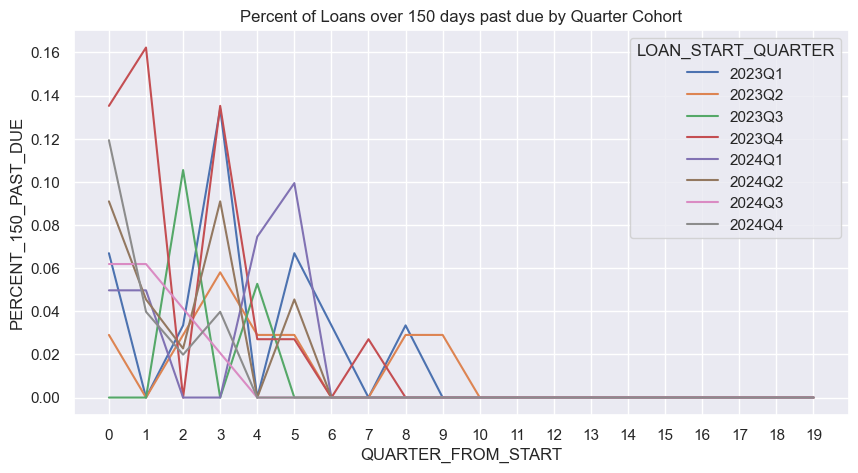

In [38]:
fig, ax = plt.subplots(figsize= (10,5))

df_vintage_perc_melted_from_2023_2024 = df_vintage_perc_melted[ (df_vintage_perc_melted["LOAN_START_QUARTER"] >= pd.Period("2023Q1", freq="Q")) & 
                                                               (df_vintage_perc_melted["LOAN_START_QUARTER"] <= pd.Period("2024Q4", freq="Q")) ]

sns.lineplot(df_vintage_perc_melted_from_2023_2024
             , x = "QUARTER_FROM_START", y="PERCENT_150_PAST_DUE", hue="LOAN_START_QUARTER"
             , ax = ax)

ax.set_title("Percent of Loans over 150 days past due by Quarter Cohort")

max_quarter_from_start = df_vintage_perc_melted_from_2023_2024["QUARTER_FROM_START"].max() +1
ax.set_xticks(range(0, max_quarter_from_start), 
              labels=range(0, max_quarter_from_start)
              )

plt.show()

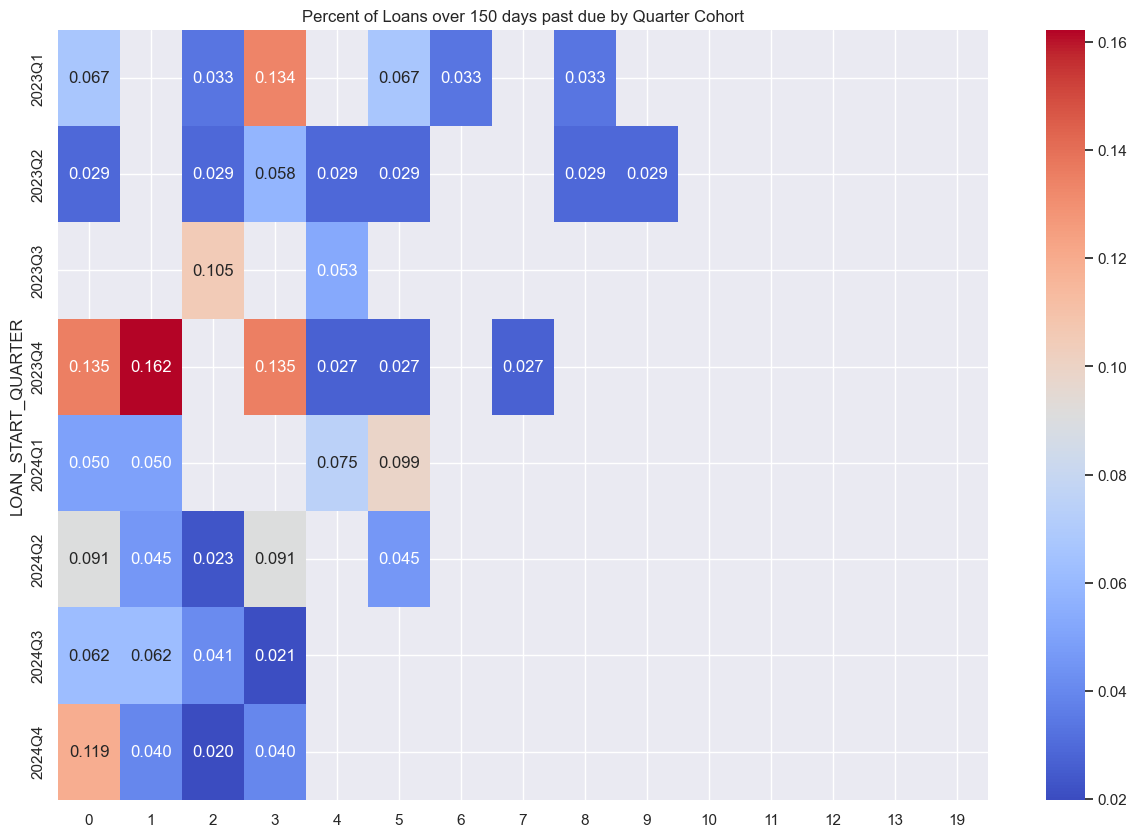

In [39]:
df_vintage_perc_from_2023_2024 = df_vintage_perc[ (df_vintage_perc.index >= pd.Period("2023Q1", freq="Q")) & 
                                                               (df_vintage_perc.index <= pd.Period("2024Q4", freq="Q")) ]

fig, ax = plt.subplots(figsize= (15,10))
sns.heatmap(df_vintage_perc_from_2023_2024, cmap="coolwarm"
            , annot=True, fmt =".3f"
            , ax=ax)
ax.set_title("Percent of Loans over 150 days past due by Quarter Cohort")
plt.show()

## Evaluate Vintage Chart

In general, cohorts from Q3 and Q4 across both years have higher deliquency rates than the first 2 annual quarters.

Cohort 2023-Q4 in particular has the highest rate of debt write-offs, or over 150 past dues within the first 4 quarters than other cohorts.

This suggests that applications towards year end could be riskier, and the approval process during these times ought to be reviewed and tightened.

The approval process for cohort 2023-Q4 also should be studied in detail to check if any criteria were too lax at that time, or if that particular cohort has distinct characteristics that correlate with higher rates of deliquency.

If such characteristics are identified, the approval process should be reviewed so that such applicants can be indentified ahead of time and have their policies and/or collection procedure adjusted accordingly.